In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from loads import *
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

PATH_FOLDER = "MovieSummaries/"

In [2]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

/Users/ahmedaziz/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie_box_office_revenue'], inplace=True)

In [5]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie_release_date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie_release_date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie_release_date'],errors='coerce').dt.month

In [7]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative_Inflation_to_2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation, on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue_with_inflation'] = movie_with_inflation['Movie_box_office_revenue'] * movie_with_inflation['Cumulative_Inflation_to_2022']
movie_with_inflation.drop(['Cumulative_Inflation_to_2022', 'Annual'], axis=1, inplace=True)

In [21]:
character_movie_merged_df = pd.merge(character_df.drop(['Movie_release_date'],axis=1), movie_with_inflation, on=['Wikipedia_movie_ID'])
actor_gender_movie_df = character_movie_merged_df[['Movie_name','Actor_name','Actor_gender', 'Revenue_with_inflation']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
actor_gender_movie_df['Percentage_Women'] = (actor_gender_movie_df.groupby('Movie_name')['Actor_gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [22]:
actor_gender_movie_df = actor_gender_movie_df.groupby('Movie_name').agg({'Actor_name': list, 'Percentage_Women' : "mean"}).reset_index()

In [24]:
movie_with_inflation = pd.merge(movie_with_inflation, actor_gender_movie_df, on= "Movie_name")

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month,Revenue_with_inflation,Actor_name,Percentage_Women
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",35.0
1,156558,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001,6.0,4.855272e+07,"[Taraji P. Henson, Tyrese Gibson, Anthony John...",52.0
2,5566878,Tortilla Soup,2001-08-24,4574762.0,103.0,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",2001,8.0,7.559723e+06,"[Tamara Mello, Elizabeth Peña, Raquel Welch, J...",50.0
3,570743,Down to Earth,2001-02-12,71186502.0,87.0,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2001,2.0,1.176346e+08,"[Regina King, Chris Rock, Eugene Levy, Frankie...",35.0
4,366111,Shallow Hal,2001-11-01,141069860.0,113.0,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",2001,11.0,2.331158e+08,"[Nan Martin, Kyle Gass, Joshua 'Li'iBoy' Shint...",47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,1995966,The Singing Fool,1928-08-17,5000000.0,105.0,[English Language],[United States of America],"[Musical, Melodrama, Drama, Musical Drama, Bla...",1928,8.0,8.557164e+07,"[Al Jolson, Betty Bronson, Josephine Dunn, Dav...",40.0
8143,24587655,A Woman of Affairs,1928-12-15,1370000.0,98.0,"[Silent film, English Language]",[United States of America],"[Silent film, Melodrama, Drama, Film adaptatio...",1928,12.0,2.344663e+07,"[Greta Garbo, Lewis Stone, John Gilbert, Dougl...",40.0
8144,25721717,The Road to Ruin,1928-03-23,2500000.0,NaN,[],[United States of America],[Silent film],1928,3.0,4.278582e+07,[Helen Foster],100.0
8145,171990,Street Angel,1928-04-09,1700000.0,102.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Drama, R...",1928,4.0,2.909436e+07,"[Charles Farrell, Janet Gaynor, Alberto Rabagl...",40.0


In [26]:
movie_with_inflation = movie_with_inflation.rename(columns={"Wikipedia_movie_ID": "Movie ID"})
movie_with_inflation = pd.merge(movie_with_inflation, plot_summaries_df, on="Movie ID")
movie_with_inflation

,Movie ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month,Revenue_with_inflation,Actor_name,Percentage_Women,Movie Summary
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",35.0,"Set in the second half of the 22nd century, th..."
1,156558,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001,6.0,4.855272e+07,"[Taraji P. Henson, Tyrese Gibson, Anthony John...",52.0,A young 20-year-old named Jody lives with his...
2,5566878,Tortilla Soup,2001-08-24,4574762.0,103.0,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",2001,8.0,7.559723e+06,"[Tamara Mello, Elizabeth Peña, Raquel Welch, J...",50.0,Semi-retired Mexican-American chef Martin Nara...
3,570743,Down to Earth,2001-02-12,71186502.0,87.0,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2001,2.0,1.176346e+08,"[Regina King, Chris Rock, Eugene Levy, Frankie...",35.0,Lance Barton is a struggling comedian who is ...
4,366111,Shallow Hal,2001-11-01,141069860.0,113.0,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",2001,11.0,2.331158e+08,"[Nan Martin, Kyle Gass, Joshua 'Li'iBoy' Shint...",47.0,Hal Larson is a superficial man whose fixatio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,9271078,Adventures of Don Juan,1948-12-01,5000000.0,110.0,"[English Language, Spanish Language]",[United States of America],"[Swashbuckler films, Adventure, Costume drama,...",1948,12.0,6.071680e+07,"[Errol Flynn, Ann Rutherford, Barbara Bates, R...",43.0,{{Cleanup-rewrite}} Late in the reign of Eliza...
7434,26018309,Silver River,1948-05-18,3484000.0,110.0,[English Language],[United States of America],"[Western, Melodrama, Drama]",1948,5.0,4.230747e+07,"[Ann Sheridan, Errol Flynn]",50.0,"During the American Civil War, soldier Mike Mc..."
7435,4499436,Way Down East,1920,4500000.0,147.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Action/A...",1920,NaN,6.584737e+07,"[Lillian Gish, Richard Barthelmess, Lowell She...",25.0,"The rich, typified by the handsome man-about-t..."
7436,1995966,The Singing Fool,1928-08-17,5000000.0,105.0,[English Language],[United States of America],"[Musical, Melodrama, Drama, Musical Drama, Bla...",1928,8.0,8.557164e+07,"[Al Jolson, Betty Bronson, Josephine Dunn, Dav...",40.0,"After years of hopeful struggle, Al Stone is ..."


In [31]:
movie_with_inflation = movie_with_inflation[['Movie ID', 'Movie_name',
       'Movie_runtime', 'Movie Languages', 'Movie Countries', 'Movie Genres',
       'Month', 'Revenue_with_inflation', 'Actor_name', 'Percentage_Women',
       'Movie Summary']]

# (7438, 11)
movie_with_inflation = movie_with_inflation.dropna()
# (6115, 11)
movie_with_inflation.shape

(6115, 11)

In [32]:
movie_summaries = plot_summaries_df.copy()

#Extract each column in a new Series variables
Movie_IDs = movie_summaries["Movie ID"].squeeze()
Movie_Summaries = movie_summaries["Movie Summary"].squeeze()

#Remove duplicate values
summary_metadata = movie_summaries.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

(42295, 2)


In [35]:
#function used to tokenize into dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

#add a column containing tokenized summaries
summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

#filter the column containing tokenized text by deleting all stopwords
summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])


/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_16373/523079212.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_16373/523079212.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower()

In [36]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column 
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata['filtered_Tokens'][:] :
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1
    
  positive_scores.append(nbr_words_pos/nbr_words)
  negative_scores.append(nbr_words_neg/nbr_words)
  neutral_scores.append(nbr_words_neu/nbr_words)

#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata["percentage of positive words"] = positive_scores
summary_metadata["percentage of negative words"] = negative_scores
summary_metadata["percentage of neutral words"] = neutral_scores
summary_metadata.head(5)

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_16373/3576238366.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of positive words"] = positive_scores
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_16373/3576238366.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of negative words"] = negative_scores
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_16373/3576238366.py:32: SettingWithCopyWarning: 
A value is t

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[shlykov, taxi, driver, lyosha, saxophonist, d...",0.083333,0.000000,0.916667
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, panem, consists, wealthy, capitol, tw...",0.037296,0.027972,0.934732
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[poovalli, induchoodan, sentenced, six, years,...",0.046099,0.046099,0.907801
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[lemon, drop, kid, new, york, city, swindler, ...",0.061269,0.041575,0.897155
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[adventist, church, pastor, michael, chamberla...",0.054726,0.039801,0.905473


In [42]:
summary_data = summary_metadata[["Movie ID","percentage of positive words","percentage of negative words","percentage of neutral words"]].copy()

movie_with_inflation = movie_with_inflation.merge(summary_data,on="Movie ID")
movie_with_inflation

,Movie ID,Movie_name,Movie_runtime,Movie Languages,Movie Countries,Movie Genres,Month,Revenue_with_inflation,Actor_name,Percentage_Women,Movie Summary,percentage of positive words,percentage of negative words,percentage of neutral words
0,975900,Ghosts of Mars,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",8.0,2.315268e+07,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",35.0,"Set in the second half of the 22nd century, th...",0.015152,0.055556,0.929293
1,156558,Baby Boy,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",6.0,4.855272e+07,"[Taraji P. Henson, Tyrese Gibson, Anthony John...",52.0,A young 20-year-old named Jody lives with his...,0.051672,0.024316,0.924012
2,5566878,Tortilla Soup,103.0,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",8.0,7.559723e+06,"[Tamara Mello, Elizabeth Peña, Raquel Welch, J...",50.0,Semi-retired Mexican-American chef Martin Nara...,0.052632,0.031579,0.915789
3,570743,Down to Earth,87.0,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2.0,1.176346e+08,"[Regina King, Chris Rock, Eugene Levy, Frankie...",35.0,Lance Barton is a struggling comedian who is ...,0.072243,0.034221,0.893536
4,366111,Shallow Hal,113.0,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",11.0,2.331158e+08,"[Nan Martin, Kyle Gass, Joshua 'Li'iBoy' Shint...",47.0,Hal Larson is a superficial man whose fixatio...,0.054645,0.043716,0.901639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,104.0,[English Language],[United States of America],"[Romantic drama, Romance Film, Melodrama, Dram...",4.0,1.315126e+07,"[Bette Davis, Jim Davis]",50.0,"Disenchanted poet Susan Grieve, escorted by he...",0.048780,0.040650,0.910569
6111,9271078,Adventures of Don Juan,110.0,"[English Language, Spanish Language]",[United States of America],"[Swashbuckler films, Adventure, Costume drama,...",12.0,6.071680e+07,"[Errol Flynn, Ann Rutherford, Barbara Bates, R...",43.0,{{Cleanup-rewrite}} Late in the reign of Eliza...,0.051546,0.051546,0.896907
6112,26018309,Silver River,110.0,[English Language],[United States of America],"[Western, Melodrama, Drama]",5.0,4.230747e+07,"[Ann Sheridan, Errol Flynn]",50.0,"During the American Civil War, soldier Mike Mc...",0.040441,0.051471,0.908088
6113,1995966,The Singing Fool,105.0,[English Language],[United States of America],"[Musical, Melodrama, Drama, Musical Drama, Bla...",8.0,8.557164e+07,"[Al Jolson, Betty Bronson, Josephine Dunn, Dav...",40.0,"After years of hopeful struggle, Al Stone is ...",0.093333,0.013333,0.893333


In [44]:
movie_with_inflation = movie_with_inflation[['Movie ID', 'Movie_name', 'Movie_runtime', 
       'Movie Languages', 'Movie Countries', 'Movie Genres', 'Month', 'Revenue_with_inflation',
       'Actor_name', 'Percentage_Women', 'percentage of positive words', 'percentage of negative words']]
movie_with_inflation.columns

Index(['Movie ID', 'Movie_name', 'Movie_runtime', 'Movie Languages',
       'Movie Countries', 'Movie Genres', 'Month', 'Revenue_with_inflation',
       'Actor_name', 'Percentage_Women', 'percentage of positive words',
       'percentage of negative words'],
      dtype='object')

In [56]:
movie_with_inflation['pos_Interval'] = pd.cut(movie_with_inflation['percentage of positive words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])
movie_with_inflation['neg_Interval'] = pd.cut(movie_with_inflation['percentage of negative words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])
movie_with_inflation = movie_with_inflation.drop(columns=['percentage of positive words', 'percentage of negative words'])

movie_with_inflation["log_revenues"] = movie_with_inflation["Revenue_with_inflation"].apply(lambda x: np.log(x))


,Movie ID,Movie_name,Movie_runtime,Movie Languages,Movie Countries,Movie Genres,Month,Revenue_with_inflation,Actor_name,Percentage_Women,pos_Interval,neg_Interval,log_revenues
0,975900,Ghosts of Mars,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",8.0,2.315268e+07,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",35.0,0-2,6-8,16.957621
1,156558,Baby Boy,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",6.0,4.855272e+07,"[Taraji P. Henson, Tyrese Gibson, Anthony John...",52.0,6-8,2-4,17.698161
2,5566878,Tortilla Soup,103.0,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",8.0,7.559723e+06,"[Tamara Mello, Elizabeth Peña, Raquel Welch, J...",50.0,6-8,2-4,15.838345
3,570743,Down to Earth,87.0,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2.0,1.176346e+08,"[Regina King, Chris Rock, Eugene Levy, Frankie...",35.0,6-8,2-4,18.583094
4,366111,Shallow Hal,113.0,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",11.0,2.331158e+08,"[Nan Martin, Kyle Gass, Joshua 'Li'iBoy' Shint...",47.0,6-8,4-6,19.267046
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,104.0,[English Language],[United States of America],"[Romantic drama, Romance Film, Melodrama, Dram...",4.0,1.315126e+07,"[Bette Davis, Jim Davis]",50.0,4-6,4-6,16.392028
6111,9271078,Adventures of Don Juan,110.0,"[English Language, Spanish Language]",[United States of America],"[Swashbuckler films, Adventure, Costume drama,...",12.0,6.071680e+07,"[Errol Flynn, Ann Rutherford, Barbara Bates, R...",43.0,6-8,6-8,17.921731
6112,26018309,Silver River,110.0,[English Language],[United States of America],"[Western, Melodrama, Drama]",5.0,4.230747e+07,"[Ann Sheridan, Errol Flynn]",50.0,4-6,6-8,17.560474
6113,1995966,The Singing Fool,105.0,[English Language],[United States of America],"[Musical, Melodrama, Drama, Musical Drama, Bla...",8.0,8.557164e+07,"[Al Jolson, Betty Bronson, Josephine Dunn, Dav...",40.0,8-10,0-2,18.264864


In [57]:
movie_with_inflation = movie_with_inflation.drop(columns=['Revenue_with_inflation'])
movie_with_inflation.columns

Index(['Movie ID', 'Movie_name', 'Movie_runtime', 'Movie Languages',
       'Movie Countries', 'Movie Genres', 'Month', 'Actor_name',
       'Percentage_Women', 'pos_Interval', 'neg_Interval', 'log_revenues'],
      dtype='object')

In [63]:
movie_with_inflation['runtime_Interval'] = pd.cut(movie_with_inflation['Movie_runtime'], bins=[0, 60, 120, 180, 240, 1000], labels=['0-60', '60-120', '120-180', '180-240', '240-1000'])
movie_with_inflation = movie_with_inflation.drop(columns=["Movie_runtime"])
# movie_with_inflation.columns
final_version = movie_with_inflation
final_version.columns

Index(['Movie ID', 'Movie_name', 'Movie Languages', 'Movie Countries',
       'Movie Genres', 'Month', 'Actor_name', 'Percentage_Women',
       'pos_Interval', 'neg_Interval', 'log_revenues', 'runtime_Interval'],
      dtype='object')

In [65]:
# Create an empty list to store DataFrames
dfs = []

# Iterate through each row of the original DataFrame
for idx, row in movie_with_inflation.iterrows():
    
    # For each genre in the 'Movie Genres' column of the current row
    for genre in row['Movie Genres']:
        
        # Create a new DataFrame with 'Genre' and 'Revenue' columns
        # Duplicate the data for each genre, using the revenue from the original row
        dfs.append(pd.DataFrame({'Genres': [genre], 'Revenue': [row['log_revenues']]}))

# Concatenate the list of DataFrames into a single DataFrame
movie_genres_df_grouped = pd.concat(dfs, ignore_index=True)

# Group the concatenated DataFrame by 'Genres' and aggregate 'Revenue' using mean and count
movie_genres_df_grouped = movie_genres_df_grouped.groupby('Genres')['Revenue'].agg({'mean', 'count'}).reset_index()

# Sort the grouped DataFrame by the count of each genre in descending order
movie_genres_df_grouped = movie_genres_df_grouped.sort_values(by='count', ascending=False)

# Display the final grouped and sorted DataFrame
display(movie_genres_df_grouped)


,Genres,count,mean
100,Drama,3182,17.024860
64,Comedy,2497,17.335381
279,Thriller,1631,17.599147
231,Romance Film,1547,17.288091
2,Action,1381,18.040180
...,...,...,...
45,Breakdance,1,17.660225
267,Supermarionation,1,18.183296
127,Film,1,12.676416
126,Fictional film,1,14.278025


In [66]:
# Set a threshold count for the number of movies in a genre
threshold = 500

# Select genres with a count greater than the threshold
top_movie_genres_df = movie_genres_df_grouped[movie_genres_df_grouped["count"] > threshold]

# Select genres with a count less than or equal to the threshold
other_movie_genre = movie_genres_df_grouped[movie_genres_df_grouped["count"] <= threshold]

# Display the DataFrame containing genres with counts above the threshold
#top_movie_genres_df


In [69]:
# List of genres you are considering
list_of_genres = np.array(top_movie_genres_df['Genres'])

# Calculate the average revenue of genres not in the list
others_revenue = (np.sum(other_movie_genre['mean']* other_movie_genre['count'])) / other_movie_genre['count'].sum()

# Calculate the counts of genres not in the list
others_count = other_movie_genre['count'].sum()

# Create a new row for 'Others' with the calculated average revenue
others_row = pd.DataFrame({'Genres': ['Others'], 'count': [others_count], 'mean': [others_revenue]})

# Concatenate the new row to the existing DataFrame
movie_genres_categories = pd.concat([top_movie_genres_df, others_row], ignore_index=True)

# Display the updated DataFrame
#movie_genres_categories

In [73]:
# Function to replace values not in the list
def replace_genres(genre_list):
    # Check if each genre in the list is in the predefined list_of_genres
    # If yes, keep the genre; otherwise, replace it with 'Other'
    return [genre if genre in list_of_genres else 'Others' for genre in genre_list]

# Apply the custom function to create a new column "primary genres"
# This column will contain the original genres if they are in list_of_genres,
# and 'Other' if they are not
movie_with_inflation["primary genres"] = movie_with_inflation["Movie Genres"].apply(replace_genres)

movie_with_inflation = movie_with_inflation.drop(columns=["Movie Genres"])

final_version = movie_with_inflation
final_version.columns

Index(['Movie ID', 'Movie_name', 'Movie Languages', 'Movie Countries', 'Month',
       'Actor_name', 'Percentage_Women', 'pos_Interval', 'neg_Interval',
       'log_revenues', 'runtime_Interval', 'primary genres'],
      dtype='object')

In [74]:
final_version

,Movie ID,Movie_name,Movie Languages,Movie Countries,Month,Actor_name,Percentage_Women,pos_Interval,neg_Interval,log_revenues,runtime_Interval,primary genres
0,975900,Ghosts of Mars,[English Language],[United States of America],8.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",35.0,0-2,6-8,16.957621,60-120,"[Thriller, Science Fiction, Horror, Adventure,..."
1,156558,Baby Boy,[English Language],[United States of America],6.0,"[Taraji P. Henson, Tyrese Gibson, Anthony John...",52.0,6-8,2-4,17.698161,120-180,"[Crime Fiction, Drama, Others]"
2,5566878,Tortilla Soup,"[English Language, Spanish Language]",[United States of America],8.0,"[Tamara Mello, Elizabeth Peña, Raquel Welch, J...",50.0,6-8,2-4,15.838345,60-120,"[Romantic comedy, Indie, Others, Others, Other..."
3,570743,Down to Earth,[English Language],"[United States of America, Australia, Canada, ...",2.0,"[Regina King, Chris Rock, Eugene Levy, Frankie...",35.0,6-8,2-4,18.583094,60-120,"[Romantic comedy, Romance Film, Fantasy, Comedy]"
4,366111,Shallow Hal,[English Language],"[United States of America, Germany]",11.0,"[Nan Martin, Kyle Gass, Joshua 'Li'iBoy' Shint...",47.0,6-8,4-6,19.267046,60-120,"[Romantic comedy, Fantasy, Comedy, Drama, Roma..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,[English Language],[United States of America],4.0,"[Bette Davis, Jim Davis]",50.0,4-6,4-6,16.392028,60-120,"[Romantic drama, Romance Film, Others, Drama, ..."
6111,9271078,Adventures of Don Juan,"[English Language, Spanish Language]",[United States of America],12.0,"[Errol Flynn, Ann Rutherford, Barbara Bates, R...",43.0,6-8,6-8,17.921731,60-120,"[Others, Adventure, Others, Others, Action/Adv..."
6112,26018309,Silver River,[English Language],[United States of America],5.0,"[Ann Sheridan, Errol Flynn]",50.0,4-6,6-8,17.560474,60-120,"[Others, Others, Drama]"
6113,1995966,The Singing Fool,[English Language],[United States of America],8.0,"[Al Jolson, Betty Bronson, Josephine Dunn, Dav...",40.0,8-10,0-2,18.264864,60-120,"[Others, Others, Drama, Others, Others]"


In [98]:
path = "csv_for_story/top_actors.csv"
top_actors = pd.read_csv(path)
used_actors = top_actors["Actor_name"]
used_actors.values

array(['Tom Cruise', 'Will Smith', 'Arnold Schwarzenegger',
       'Eddie Murphy', 'Mike Myers', 'Frank Oz', 'Robert Redford',
       'Jim Carrey', 'Hugo Weaving', 'Harrison Ford', 'Maggie Smith',
       'Sally Field', 'Tom Hanks', 'Emma Thompson', 'Brad Pitt',
       'Brad Garrett', 'Sean Connery', 'Jim Cummings', 'Mel Gibson',
       'Cameron Diaz', 'Helena Bonham Carter', 'Christopher Lee',
       'George Clooney', 'Dustin Hoffman', 'Leonardo DiCaprio',
       'Michael J. Fox', 'Chris Rock', 'Martin Lawrence',
       'Pete Postlethwaite', 'Hugh Jackman', 'Adam Sandler',
       'Harry Shearer', 'Geoffrey Rush', 'Jada Pinkett Smith',
       'Frank Welker', 'Jack Nicholson', 'Sylvester Stallone',
       'Clint Eastwood', 'Meryl Streep', 'Angelina Jolie', 'Jonah Hill',
       'Bernie Mac', 'Robin Williams', 'Jamie Foxx', 'Michael Douglas',
       'Scarlett Johansson', 'Gary Oldman', 'Sam Elliott',
       'Max von Sydow', 'Bruce Willis', 'George Kennedy', 'Pat Hingle',
       'Ashton Kut

In [101]:
# Calculate the proportion of specific actors in each movie
final_version['specific_actors_ratio'] = final_version['Actor_name'].apply(lambda x: len([actor for actor in x if actor in used_actors.values]) / len(x))
final_version = final_version.drop(columns=["Actor_name"])
final_version

,Movie ID,Movie_name,Movie Languages,Movie Countries,Month,Percentage_Women,pos_Interval,neg_Interval,log_revenues,runtime_Interval,primary genres,specific_actors_ratio
0,975900,Ghosts of Mars,[English Language],[United States of America],8.0,35.0,0-2,6-8,16.957621,60-120,"[Thriller, Science Fiction, Horror, Adventure,...",0.117647
1,156558,Baby Boy,[English Language],[United States of America],6.0,52.0,6-8,2-4,17.698161,120-180,"[Crime Fiction, Drama, Others]",0.043478
2,5566878,Tortilla Soup,"[English Language, Spanish Language]",[United States of America],8.0,50.0,6-8,2-4,15.838345,60-120,"[Romantic comedy, Indie, Others, Others, Other...",0.100000
3,570743,Down to Earth,[English Language],"[United States of America, Australia, Canada, ...",2.0,35.0,6-8,2-4,18.583094,60-120,"[Romantic comedy, Romance Film, Fantasy, Comedy]",0.250000
4,366111,Shallow Hal,[English Language],"[United States of America, Germany]",11.0,47.0,6-8,4-6,19.267046,60-120,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",0.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,[English Language],[United States of America],4.0,50.0,4-6,4-6,16.392028,60-120,"[Romantic drama, Romance Film, Others, Drama, ...",0.000000
6111,9271078,Adventures of Don Juan,"[English Language, Spanish Language]",[United States of America],12.0,43.0,6-8,6-8,17.921731,60-120,"[Others, Adventure, Others, Others, Action/Adv...",0.000000
6112,26018309,Silver River,[English Language],[United States of America],5.0,50.0,4-6,6-8,17.560474,60-120,"[Others, Others, Drama]",0.000000
6113,1995966,The Singing Fool,[English Language],[United States of America],8.0,40.0,8-10,0-2,18.264864,60-120,"[Others, Others, Drama, Others, Others]",0.000000


In [105]:
path = "csv_for_story/countries_df_grouped_jerry.csv"
movie_countries_df_grouped = pd.read_csv(path)

# Set a threshold count for the number of movies in a country
threshold = 50

# Select countries with a count greater than the threshold
top_movie_countries_df = movie_countries_df_grouped[movie_countries_df_grouped["count"] > threshold]
top_countries = top_movie_countries_df["Country"]
top_countries

10                       China
14    United States of America
15                     Germany
19                   Australia
21                       Japan
22              United Kingdom
23                   Hong Kong
26                       Italy
27                 New Zealand
29                      France
30                       Spain
33                      Canada
48                     Ireland
56                 South Korea
Name: Country, dtype: object

In [111]:
final_version = final_version.copy()
# Calculate the proportion of specific actors in each movie
final_version['specific_countries_ratio'] = final_version['Movie Countries'].apply(lambda x: len([actor for actor in x if actor in top_countries.values]) / len(x) if x else 0)
final_version = final_version.drop(columns=["Movie Countries"])
final_version

,Movie ID,Movie_name,Movie Languages,Month,Percentage_Women,pos_Interval,neg_Interval,log_revenues,runtime_Interval,primary genres,specific_actors_ratio,specific_countries_ratio
0,975900,Ghosts of Mars,[English Language],8.0,35.0,0-2,6-8,16.957621,60-120,"[Thriller, Science Fiction, Horror, Adventure,...",0.117647,1.0
1,156558,Baby Boy,[English Language],6.0,52.0,6-8,2-4,17.698161,120-180,"[Crime Fiction, Drama, Others]",0.043478,1.0
2,5566878,Tortilla Soup,"[English Language, Spanish Language]",8.0,50.0,6-8,2-4,15.838345,60-120,"[Romantic comedy, Indie, Others, Others, Other...",0.100000,1.0
3,570743,Down to Earth,[English Language],2.0,35.0,6-8,2-4,18.583094,60-120,"[Romantic comedy, Romance Film, Fantasy, Comedy]",0.250000,1.0
4,366111,Shallow Hal,[English Language],11.0,47.0,6-8,4-6,19.267046,60-120,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",0.176471,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,[English Language],4.0,50.0,4-6,4-6,16.392028,60-120,"[Romantic drama, Romance Film, Others, Drama, ...",0.000000,1.0
6111,9271078,Adventures of Don Juan,"[English Language, Spanish Language]",12.0,43.0,6-8,6-8,17.921731,60-120,"[Others, Adventure, Others, Others, Action/Adv...",0.000000,1.0
6112,26018309,Silver River,[English Language],5.0,50.0,4-6,6-8,17.560474,60-120,"[Others, Others, Drama]",0.000000,1.0
6113,1995966,The Singing Fool,[English Language],8.0,40.0,8-10,0-2,18.264864,60-120,"[Others, Others, Drama, Others, Others]",0.000000,1.0


In [112]:
# Load the data
path = "csv_for_story/languages_df_grouped_jerry.csv"
movie_languages_df_grouped = pd.read_csv(path)

In [115]:
# Set a threshold count for the number of movies in a language
threshold = 50

# Select languages with a count greater than the threshold
top_movie_languages_df = movie_languages_df_grouped[movie_languages_df_grouped["count"] > threshold]
top_languages = top_movie_languages_df["Language"]
top_languages

52      Italian Language
54       Arabic Language
59      Russian Language
61       German Language
64      Spanish Language
68     Standard Mandarin
70       French Language
73             Cantonese
74     Japanese Language
84      English Language
110      Korean Language
Name: Language, dtype: object

In [118]:
final_version = final_version.copy()
# Calculate the proportion of specific actors in each movie
final_version['specific_languages_ratio'] = final_version['Movie Languages'].apply(lambda x: len([actor for actor in x if actor in top_languages.values]) / len(x) if x else 0)
final_version = final_version.drop(columns=["Movie Languages"])
final_version.columns

KeyError: 'Movie Languages'

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

all_values = set(val for sublist in final_version['primary genres'] for val in sublist)

exploded = final_version['primary genres'].explode()

# Get dummy variables for each unique value
dummies = pd.get_dummies(exploded)

# Group by the original index and sum to get binary representation
one_hot_encoded = dummies.groupby(dummies.index).mean()

# Join the one-hot encoded DataFrame back to the original DataFrame
final_version = final_version.join(one_hot_encoded)

final_version = final_version.drop(columns=["primary genres"])
final_version.columns

NameError: name 'final_version' is not defined

In [129]:
final_version = final_version.drop(columns=["primary genres"])


KeyError: "['primary genres'] not found in axis"

In [130]:
final_version

,Movie ID,Movie_name,Month,Percentage_Women,pos_Interval,neg_Interval,log_revenues,runtime_Interval,specific_actors_ratio,specific_countries_ratio,...,Horror,Indie,Mystery,Others,Period piece,Romance Film,Romantic comedy,Romantic drama,Science Fiction,Thriller
0,975900,Ghosts of Mars,8.0,35.0,0-2,6-8,16.957621,60-120,0.117647,1.0,...,0.142857,0.000000,0.0,0.285714,0.0,0.000000,0.000000,0.000000,0.142857,0.142857
1,156558,Baby Boy,6.0,52.0,6-8,2-4,17.698161,120-180,0.043478,1.0,...,0.000000,0.000000,0.0,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,5566878,Tortilla Soup,8.0,50.0,6-8,2-4,15.838345,60-120,0.100000,1.0,...,0.000000,0.111111,0.0,0.333333,0.0,0.111111,0.111111,0.111111,0.000000,0.000000
3,570743,Down to Earth,2.0,35.0,6-8,2-4,18.583094,60-120,0.250000,1.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.250000,0.250000,0.000000,0.000000,0.000000
4,366111,Shallow Hal,11.0,47.0,6-8,4-6,19.267046,60-120,0.176471,1.0,...,0.000000,0.000000,0.0,0.285714,0.0,0.142857,0.142857,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,14348806,Winter Meeting,4.0,50.0,4-6,4-6,16.392028,60-120,0.000000,1.0,...,0.000000,0.000000,0.0,0.400000,0.0,0.200000,0.000000,0.200000,0.000000,0.000000
6111,9271078,Adventures of Don Juan,12.0,43.0,6-8,6-8,17.921731,60-120,0.000000,1.0,...,0.000000,0.000000,0.0,0.428571,0.0,0.142857,0.000000,0.000000,0.000000,0.000000
6112,26018309,Silver River,5.0,50.0,4-6,6-8,17.560474,60-120,0.000000,1.0,...,0.000000,0.000000,0.0,0.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6113,1995966,The Singing Fool,8.0,40.0,8-10,0-2,18.264864,60-120,0.000000,1.0,...,0.000000,0.000000,0.0,0.800000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [152]:
final_version.to_csv("final_version_dataset.csv")

In [7]:
budget = pd.read_csv("movies.csv")
budget = budget.dropna()
budget = budget[["name", "budget", "company", "score", "rating"]]
budget = budget.rename(columns={"name" : "Movie_name"})

budget_final = budget.copy()

budget.columns

Index(['Movie_name', 'budget', 'company', 'score', 'rating'], dtype='object')

In [8]:
budget['budget'] = (budget['budget'] - budget['budget'].min()) / (budget['budget'].max() - budget['budget'].min())
budget['score'] = (budget['score'] - budget['score'].min()) / (budget['score'].max() - budget['score'].min())
budget
# One-hot encode 'company' and 'rating' columns
budget = pd.get_dummies(budget, columns=[ 'company','rating'], prefix=['company','rating'])
budget

,Movie_name,budget,score,"company_""DIA"" Productions GmbH & Co. KG","company_""Weathering With You"" Film Partners",company_.406 Production,company_1492 Pictures,company_1818 Productions,company_19 Entertainment,company_1978 Films,...,rating_Approved,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-MA,rating_Unrated,rating_X
0,The Shining,0.053355,0.878378,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,The Blue Lagoon,0.012624,0.527027,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,Star Wars: Episode V - The Empire Strikes Back,0.050546,0.918919,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,Airplane!,0.009815,0.783784,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,Caddyshack,0.016837,0.729730,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,0.252796,0.635135,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7649,Sonic the Hedgehog,0.238751,0.621622,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
7650,Dolittle,0.491564,0.500000,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
7651,The Call of the Wild,0.379203,0.662162,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [9]:
x = pd.read_csv("final_version_dataset.csv")
x = x.dropna()

In [419]:
final = x.copy()
x["Movie_name"] = x["Movie_name"].astype(str)
x = pd.merge(x, budget, on="Movie_name")
x = x.dropna()

In [420]:

final = pd.merge(final, budget_final, on="Movie_name").dropna()

Y = x['log_revenues']
X = x.drop(columns=["log_revenues","Unnamed: 0", "Movie ID","Movie_name"])  # Include more variables as needed
X = sm.add_constant(X)  # Adds a constant term to the predictor
# Select columns to one-hot encode
X['Month'] = X['Month'].astype('category')
X["Percentage_Women"]  = X["Percentage_Women"]/100
categorical_cols = ["Month",'pos_Interval', 'neg_Interval', 'runtime_Interval']

# Apply one-hot encoding
encoded_cols = pd.get_dummies(X[categorical_cols])

# Join the encoded dataframe with the original dataframe
X = X.join(encoded_cols).drop(columns=categorical_cols)
X = X.astype(float)
X

,const,Percentage_Women,specific_actors_ratio,specific_countries_ratio,specific_languages_ratio,Action,Action/Adventure,Adventure,Comedy,Crime Fiction,...,neg_Interval_0-2,neg_Interval_2-4,neg_Interval_4-6,neg_Interval_6-8,neg_Interval_8-10,runtime_Interval_0-60,runtime_Interval_120-180,runtime_Interval_180-240,runtime_Interval_240-1000,runtime_Interval_60-120
0,1.0,0.35,0.117647,1.0,1.0,0.142857,0.000000,0.142857,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.52,0.043478,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.35,0.250000,1.0,1.0,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.47,0.176471,1.0,1.0,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.50,0.590909,1.0,1.0,0.000000,0.000000,0.000000,0.250000,0.250000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1.0,0.53,0.076923,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3197,1.0,0.21,0.142857,1.0,1.0,0.000000,0.000000,0.125000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3198,1.0,0.37,0.000000,1.0,1.0,0.142857,0.142857,0.000000,0.000000,0.142857,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3199,1.0,0.37,0.250000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [421]:
model = sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     6.038
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          2.10e-261
Time:                        15:20:39   Log-Likelihood:                -4218.9
No. Observations:                3201   AIC:                         1.015e+04
Df Residuals:                    2345   BIC:                         1.535e+04
Df Model:                         855                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [422]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get the predicted values
y_pred = model.predict(X)

# Calculate MAE
mae = mean_absolute_error(Y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y, y_pred))

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.6181259670816089
Root Mean Squared Error (RMSE): 0.903981657004405


In [423]:
threshold = 1.5
# Calculate the absolute difference
abs_diff = Y - y_pred

# Get the indices where abs_diff is larger than 2
indices_below = np.where(abs_diff > threshold)
indices_above = np.where(abs_diff < -threshold)
# Print the indices
print(f"Indices where abs_diff > {threshold}:", indices_below[0].shape)
print(f"Indices where abs_diff < -{threshold}:", indices_above[0].shape)

Indices where abs_diff > 1.5: (116,)
Indices where abs_diff < -1.5: (176,)


(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   3.,   5.,   5.,
          2.,   3.,   5.,   5.,   7.,   7.,   5.,  12.,  14.,  29.,  20.,
         41.,  55.,  68.,  83.,  90., 124., 170., 193., 216., 781., 217.,
        207., 221., 174., 132.,  96.,  67.,  53.,  29.,  23.,  17.,   6.,
          5.,   2.,   1.,   1.,   0.,   3.]),
 array([-5.76164619, -5.57742863, -5.39321108, -5.20899352, -5.02477597,
        -4.84055842, -4.65634086, -4.47212331, -4.28790575, -4.1036882 ,
        -3.91947064, -3.73525309, -3.55103553, -3.36681798, -3.18260042,
        -2.99838287, -2.81416531, -2.62994776, -2.44573021, -2.26151265,
        -2.0772951 , -1.89307754, -1.70885999, -1.52464243, -1.34042488,
        -1.15620732, -0.97198977, -0.78777221, -0.60355466, -0.41933711,
        -0.23511955, -0.050902  ,  0.13331556,  0.31753311,  0.50175067,
         0.68596822,  0.87018578,  1.05440333,  1.23862089,  1.42283844,
         1.607056  ,  1.79127355,  1.9754911 ,  2.15970866,  2.34392621,
 

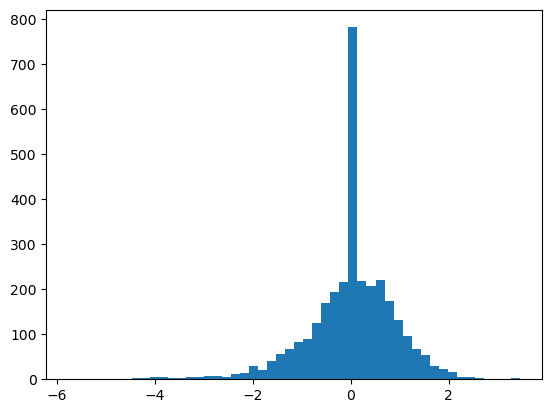

In [424]:
plt.hist(Y- y_pred,bins=50)

In [428]:
outliers_below = final.iloc[indices_below[0]]
outliers_above = final.iloc[indices_above[0]]

In [450]:
outliers_below = final.iloc[indices_below[0]]
outliers_above = final.iloc[indices_above[0]]
columns_to_consider = ['Month', 'Percentage_Women',
       'pos_Interval', 'neg_Interval', 'runtime_Interval',
       'specific_actors_ratio', 'specific_countries_ratio',
       'specific_languages_ratio',
       'budget', 'company', 'score', 'rating']

outliers_below.shape
below_list, above_list = [] , []

for col in columns_to_consider :
    condition_below = outliers_below[col].unique().shape[0]/final[col].unique().shape[0]
    condition_above = outliers_above[col].unique().shape[0]/final[col].unique().shape[0]

    if condition_below < 0.5: 
        print("below ", col , " ",  outliers_below[col].unique() , " \n", final[col].unique()) 
        below_list.append(col)
    if condition_above < 0.5: 
        print("above ", col , " ",  outliers_above[col].unique() , " \n", final[col].unique()) 
        above_list.append(col)

above  runtime_Interval   ['60-120' '120-180']  
 ['60-120' '120-180' '180-240' '240-1000' '0-60']
below  specific_actors_ratio   [0.36363636 0.21052632 0.375      0.2        0.33333333 0.28571429
 0.14285714 0.06666667 0.         0.46153846 0.20512821 0.13333333
 0.125      0.0952381  0.42857143 0.05263158 0.08695652 0.21428571
 0.5        0.22222222 0.1        0.25       0.18181818 0.07142857
 0.4        0.43589744 0.23076923 0.03030303 0.22580645 0.16666667
 0.17647059 0.41666667 0.63636364 0.3125     0.15789474 0.11111111
 0.6        0.05882353 0.26315789 0.15384615 0.66666667 0.23529412
 0.08333333 0.4375     0.24       0.42105263 0.72727273 0.625
 0.08823529 0.27272727 0.41176471 0.15       0.58333333 0.83333333
 0.3       ]  
 [0.11764706 0.04347826 0.25       0.17647059 0.59090909 0.1875
 0.07692308 0.21052632 0.18181818 0.16666667 0.11111111 0.22222222
 0.33333333 0.28571429 0.2        0.66666667 0.36363636 0.09090909
 0.38461538 0.         0.14285714 0.375      0.44444444 0.4

In [451]:
print(above_list)
print(below_list)

['runtime_Interval', 'specific_actors_ratio', 'specific_countries_ratio', 'specific_languages_ratio', 'budget', 'company']
['specific_actors_ratio', 'specific_countries_ratio', 'specific_languages_ratio', 'budget', 'company']


# dealing with below outliers

In [1]:
import plotly.express as px

# Data preparation
data_above = outliers_above['runtime_Interval'].value_counts()
data_final = final['runtime_Interval'].value_counts()

# Adding unused categories in grey
for category in data_final.index:
    if category not in data_above.index:
        data_above[category] = 0

# Generating plot
fig = px.pie(names=data_above.index, values=data_above.values, title='Runtime Interval Distribution in Outliers (Above Threshold)')
fig.update_traces(marker=dict(colors=['blue', 'orange', 'green', 'red', 'purple', 'grey']))
fig.show()


# Data preparation
data_below = outliers_below['runtime_Interval'].value_counts()

# Adding unused categories in grey
for category in data_final.index:
    if category not in data_below.index:
        data_below[category] = 0

# Generating plot
fig = px.pie(names=data_below.index, values=data_below.values, title='Runtime Interval Distribution in Outliers (Below Threshold)')
fig.update_traces(marker=dict(colors=['blue', 'orange', 'green', 'red', 'purple', 'grey']))
fig.show()

NameError: name 'outliers_above' is not defined

In [462]:
import plotly.express as px

# Data preparation for 'specific_actors_ratio'
data_above_actors = outliers_above['specific_actors_ratio'].value_counts(normalize=True)

# Grouping smaller categories into 'Others'
other_threshold = 0.01  # 1%
small_categories = data_above_actors[data_above_actors < other_threshold].index
data_above_actors = data_above_actors[data_above_actors >= other_threshold]
data_above_actors['Others'] = sum(data_above_actors[small_categories])

# Adding unused categories in grey
data_final_actors = final['specific_actors_ratio'].value_counts(normalize=True)
for category in data_final_actors.index:
    if category not in data_above_actors.index and data_final_actors[category] >= other_threshold:
        data_above_actors[category] = 0

# Generating plot
fig = px.pie(names=data_above_actors.index, values=data_above_actors.values, title='Specific Actors Ratio in Outliers (Above Threshold)')
fig.update_traces(marker=dict(colors=['blue', 'orange', 'green', 'red', 'purple', 'grey'] * (len(data_above_actors.index)//5 + 1)))
fig.show()


KeyError: "None of [Index([0.1923076923076923, 0.1538461538461538, 0.6666666666666666,\n       0.5333333333333333, 0.0555555555555555, 0.2352941176470588,\n                   0.3125, 0.0434782608695652, 0.2105263157894736,\n       0.2142857142857142, 0.4117647058823529,             0.5625,\n       0.7272727272727273, 0.2857142857142857, 0.6428571428571429,\n       0.0833333333333333,                0.6, 0.3529411764705882,\n       0.1304347826086956,               0.35, 0.5833333333333334,\n       0.5555555555555556, 0.3888888888888889,             0.4375,\n       0.7142857142857143, 0.1935483870967742, 0.1052631578947368,\n       0.4166666666666667, 0.0526315789473684],\n      dtype='float64', name='specific_actors_ratio')] are in the [index]"

In [463]:
import plotly.express as px

# Assuming you have a dictionary mapping numbers to country names
# Example: country_mapping = {1: 'USA', 2: 'UK', ...}
country_mapping = {}  # Replace with your actual mapping

# Data preparation for 'specific_countries_ratio'
data_below_countries = outliers_below['specific_countries_ratio'].value_counts()
data_final_countries = final['specific_countries_ratio'].value_counts()

# Renaming labels with country names
data_below_countries.index = [country_mapping.get(idx, idx) for idx in data_below_countries.index]
data_final_countries.index = [country_mapping.get(idx, idx) for idx in data_final_countries.index]

# Grouping smaller categories into 'Others'
data_below_countries = data_below_countries[data_below_countries > 0]
data_below_countries['Others'] = sum(data_final_countries[~data_final_countries.index.isin(data_below_countries.index)])

# Generating plot
fig = px.pie(names=data_below_countries.index, values=data_below_countries.values, title='Specific Countries Ratio in Outliers (Below Threshold)')
colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey'] * (len(data_below_countries.index)//5 + 1)
fig.update_traces(marker=dict(colors=colors))
fig.show()
